# Phishing Detection Model Training with WandB

This notebook trains and evaluates three phishing detection models:
1. **TF-IDF + Logistic Regression** (baseline)
2. **Hybrid XGBoost** (text embeddings + engineered features)
3. **Hybrid MLP** (text embeddings + engineered features)

All experiments are tracked using Weights & Biases for reproducibility and comparison.

## 1. Install and Import Required Libraries

In [ ]:
import os
import sys
import json
import pickle
from datetime import datetime
from pathlib import Path
import numpy as np
import polars as pl
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import wandb
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, fbeta_score
)
from sentence_transformers import SentenceTransformer
import xgboost as xgb
import optuna
from optuna.integration.wandb import WeightsAndBiasesCallback

import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append(str(Path.cwd().parent.parent))

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")
print(f"Optuna version: {optuna.__version__}")

c:\Users\Latandu\AppData\Local\pypoetry\Cache\virtualenvs\phishstop-fgAazRW6-py3.12\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch version: 2.5.1+cu121
CUDA available: True
Device: cuda
Optuna version: 4.6.0


## 2. Configure WandB and Experiment Settings

In [3]:
wandb.login()

config = {
    "random_seed": 42,
    "train_split": 0.6,
    "test_split": 0.2,
    "external_split": 0.2,
    "data_source": "emails_v6.parquet",
    
    "numeric_features": [
        "sender_domain_entropy", "has_attachment",
        "spf_flag_missing", "dkim_flag_missing",
        "num_links", "subject_length", "body_length", "keyword_count", 
        "num_received_headers", "num_exclamation_marks", 
        "num_malicious_links"
    ],
    "embedding_model": "all-MiniLM-L6-v2",
    "embedding_dim": 384,
    
    "tfidf_max_features": 10000,
    "tfidf_ngram_range": (1, 2),
    "tfidf_min_df": 8,
    "tfidf_max_df": 0.9,
    "tfidf_threshold": 0.45,
    "lr_max_iter": 1000,
    "lr_C": 5.537277379395257,
    "lr_class_weight_ratio": 8.5,
    
    "xgb_max_depth": 7,
    "xgb_n_estimators": 400,
    "xgb_learning_rate": 0.0846751074136459,
    "xgb_min_child_weight": 7,
    "xgb_subsample": 0.9,
    "xgb_colsample_bytree": 0.95,
    "xgb_scale_pos_weight": 7.0,
    "xgb_threshold": 0.45,
    "xgb_early_stopping": 10,
    
    "mlp_feature_hidden_dim": 128,
    "mlp_dropout": 0.5,
    "mlp_lr": 0.0005957412292147004,
    "mlp_weight_decay": 0.00023686574806450268,
    "mlp_epochs": 50,
    "mlp_batch_size": 128,
    "mlp_pos_weight": 2.0,
    "mlp_threshold": 0.4,
    "mlp_early_stopping": 5,
}
wandb.init(project="phishstop-hyperparameter-tuning", config=config)


wandb: Currently logged in as: latandu (latandu-phishstop) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


## 3. Load and Prepare Dataset

In [4]:
df = pl.read_parquet("../../emails_v6.parquet")
pl.Config.set_tbl_rows(-1)
print(df.select("source").unique())
print(f"Total records: {len(df):,}")
print(f"Columns: {df.columns}")

phishing_count = df.filter(pl.col("phishing") == 1).shape[0]
legit_count = df.filter(pl.col("phishing") == 0).shape[0]

print(f"Class distribution:")
print(f"Phishing: {phishing_count:,} ({phishing_count/len(df)*100:.2f}%)")
print(f"Legitimate: {legit_count:,} ({legit_count/len(df)*100:.2f}%)")

wandb.log({
    "total_records": len(df),
    "phishing_count": phishing_count,
    "legit_count": legit_count,
    "class_balance": phishing_count / len(df)
})

shape: (22, 1)
┌────────────────────────────┐
│ source                     │
│ ---                        │
│ str                        │
╞════════════════════════════╡
│ phishing-2013              │
│ data/csv_misc/TREC-06.csv  │
│ phishing-2020              │
│ phishing-2016              │
│ phishing-2021              │
│ phishing-2014              │
│ mbox_gradzki.mbox          │
│ mbox_andrunik.mbox         │
│ data/csv_misc/Enron.csv    │
│ phishing-2023              │
│ phishing-2022              │
│ data/csv_misc/TREC-05.csv  │
│ phishing-nigerian          │
│ phishing-2024              │
│ data/csv_misc/TREC-07.csv  │
│ data/csv_misc/Ling.csv     │
│ data/csv_misc/Assassin.csv │
│ data/csv_misc/CEAS-08.csv  │
│ phishing-2019              │
│ phishing-2015              │
│ phishing-2017              │
│ phishing-2018              │
└────────────────────────────┘
Total records: 212,113
Columns: ['source', 'phishing', 'spf_flag', 'dkim_flag', 'd_flag', 'num_received_headers', 'bo

## 3.1. Dataset Distribution Analysis

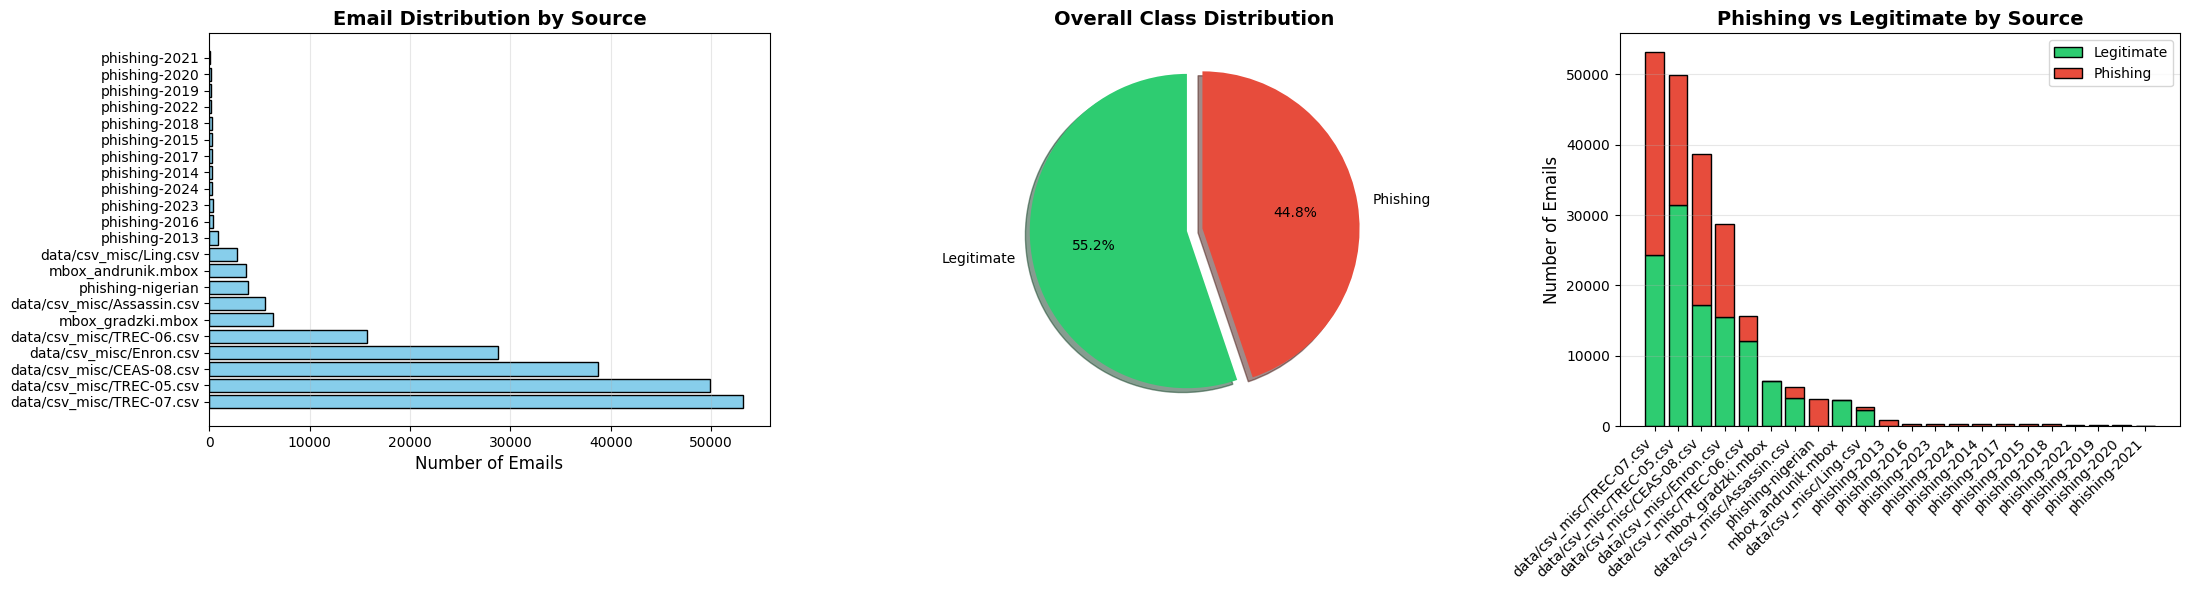

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import wandb
import polars as pl

df_pd = df.to_pandas()

source_counts = df.group_by("source").agg([
    pl.len().alias("count"),
    pl.col("phishing").sum().alias("phishing_count"),
    pl.col("phishing").mean().alias("phishing_ratio")
]).sort("count", descending=True)

source_counts = source_counts.with_columns([
    (pl.col("count") - pl.col("phishing_count")).alias("legitimate_count")
])

source_data = source_counts.to_pandas()

fig, axes = plt.subplots(1, 3, figsize=(22, 6))

axes[0].barh(source_data['source'], source_data['count'], color='skyblue', edgecolor='black')
axes[0].set_xlabel('Number of Emails', fontsize=12)
axes[0].set_title('Email Distribution by Source', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)


class_counts = [source_data['legitimate_count'].sum(), source_data['phishing_count'].sum()]
colors_pie = ['#2ecc71', '#e74c3c']
axes[1].pie(class_counts, labels=['Legitimate', 'Phishing'], autopct='%1.1f%%', 
            colors=colors_pie, explode=(0.05, 0.05), shadow=True, startangle=90)
axes[1].set_title('Overall Class Distribution', fontsize=14, fontweight='bold')

x_pos = np.arange(len(source_data))
axes[2].bar(x_pos, source_data['legitimate_count'], label='Legitimate', color='#2ecc71', edgecolor='black')
axes[2].bar(x_pos, source_data['phishing_count'], bottom=source_data['legitimate_count'],
            label='Phishing', color='#e74c3c', edgecolor='black')
axes[2].set_xticks(x_pos)
axes[2].set_xticklabels(source_data['source'], rotation=45, ha='right')
axes[2].set_ylabel('Number of Emails', fontsize=12)
axes[2].set_title('Phishing vs Legitimate by Source', fontsize=14, fontweight='bold')
axes[2].legend()
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()

wandb.log({"dataset_analysis/source_distribution": wandb.Image(fig)})
wandb.log({"dataset_analysis/source_table": wandb.Table(
    columns=["source", "count", "phishing_count", "legitimate_count", "phishing_ratio"],
    data=source_data[['source', 'count', 'phishing_count', 'legitimate_count', 'phishing_ratio']].values.tolist()
)})

plt.show()
plt.close()


Legitimate Emails:
Total Length (body + subject): mean=2139.2, median=1063.0, std=11333.4
  Subject Length: mean=38.1, median=34.0
  Body Length: mean=2099.1, median=1023.0
Phishing Emails:
Total Length (body + subject): mean=1201.2, median=626.0, std=3013.2
  Subject Length: mean=34.4, median=30.0
  Body Length: mean=1164.8, median=591.0


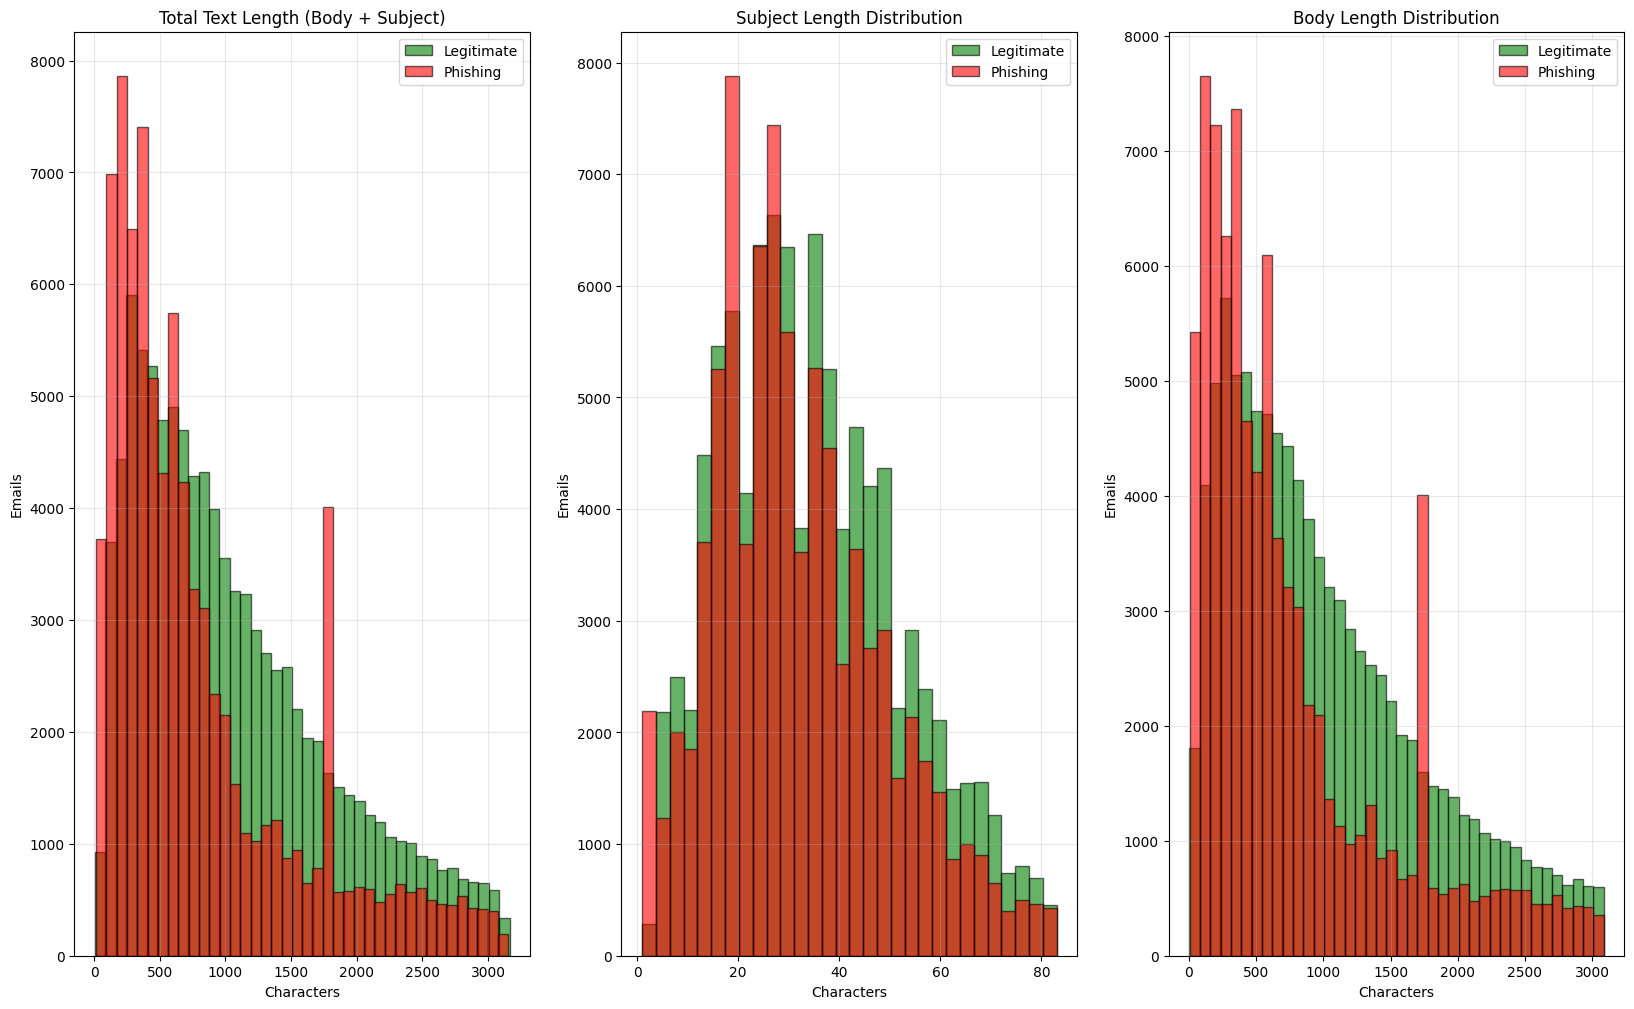

In [6]:
df_pd["body_subject_length"] = df_pd["body_subject"].str.len()
df_pd["subject_length_actual"] = df_pd["subject"].str.len()
df_pd["body_length_actual"] = df_pd["body_text"].str.len()


for label, name in [(0, "Legitimate"), (1, "Phishing")]:
    subset = df_pd[df_pd["phishing"] == label]

    print(f"{name} Emails:")
    print(f"Total Length (body + subject): "
          f"mean={subset['body_subject_length'].mean():.1f}, "
          f"median={subset['body_subject_length'].median():.1f}, "
          f"std={subset['body_subject_length'].std():.1f}")

    print(f"  Subject Length: mean={subset['subject_length_actual'].mean():.1f}, "
          f"median={subset['subject_length_actual'].median():.1f}")

    print(f"  Body Length: mean={subset['body_length_actual'].mean():.1f}, "
          f"median={subset['body_length_actual'].median():.1f}")

def remove_iqr_outliers_df(df, columns):
    df_clean = df.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]
    return df_clean

length_cols = ["body_subject_length", "subject_length_actual", "body_length_actual"]
df_vis = remove_iqr_outliers_df(df_pd, length_cols)

LEGIT = df_vis[df_vis["phishing"] == 0]
PHISH = df_vis[df_vis["phishing"] == 1]

fig, axes = plt.subplots(1, 3, figsize=(20, 12))
axes = axes.flatten()


ax = axes[0]
ax.hist(LEGIT["body_subject_length"], bins=40, alpha=0.6,
        label="Legitimate", color="green", edgecolor="black")
ax.hist(PHISH["body_subject_length"], bins=40, alpha=0.6,
        label="Phishing", color="red", edgecolor="black")
ax.set_title("Total Text Length (Body + Subject)")
ax.set_xlabel("Characters")
ax.set_ylabel("Emails")
ax.grid(alpha=0.3)
ax.legend()

ax = axes[1]
ax.hist(LEGIT["subject_length_actual"], bins=30, alpha=0.6,
        label="Legitimate", color="green", edgecolor="black")
ax.hist(PHISH["subject_length_actual"], bins=30, alpha=0.6,
        label="Phishing", color="red", edgecolor="black")
ax.set_title("Subject Length Distribution")
ax.set_xlabel("Characters")
ax.set_ylabel("Emails")
ax.grid(alpha=0.3)
ax.legend()


ax = axes[2]
ax.hist(LEGIT["body_length_actual"], bins=40, alpha=0.6,
        label="Legitimate", color="green", edgecolor="black")
ax.hist(PHISH["body_length_actual"], bins=40, alpha=0.6,
        label="Phishing", color="red", edgecolor="black")
ax.set_title("Body Length Distribution")
ax.set_xlabel("Characters")
ax.set_ylabel("Emails")
ax.grid(alpha=0.3)
ax.legend()

stats_table = []
for label, name in [(0, "Legitimate"), (1, "Phishing")]:
    subset = df_pd[df_pd["phishing"] == label]
    stats_table.append([
        name,
        subset["body_subject_length"].mean(),
        subset["body_subject_length"].median(),
        subset["body_subject_length"].std(),
        subset["subject_length_actual"].mean(),
        subset["body_length_actual"].mean(),
    ])

wandb.log({
    "dataset_analysis/text_length_stats": wandb.Table(
        columns=[
            "class",
            "avg_total_length",
            "median_total_length",
            "std_total_length",
            "avg_subject_length",
            "avg_body_length",
        ],
        data=stats_table
    )
})


Error: You must call wandb.init() before wandb.log()

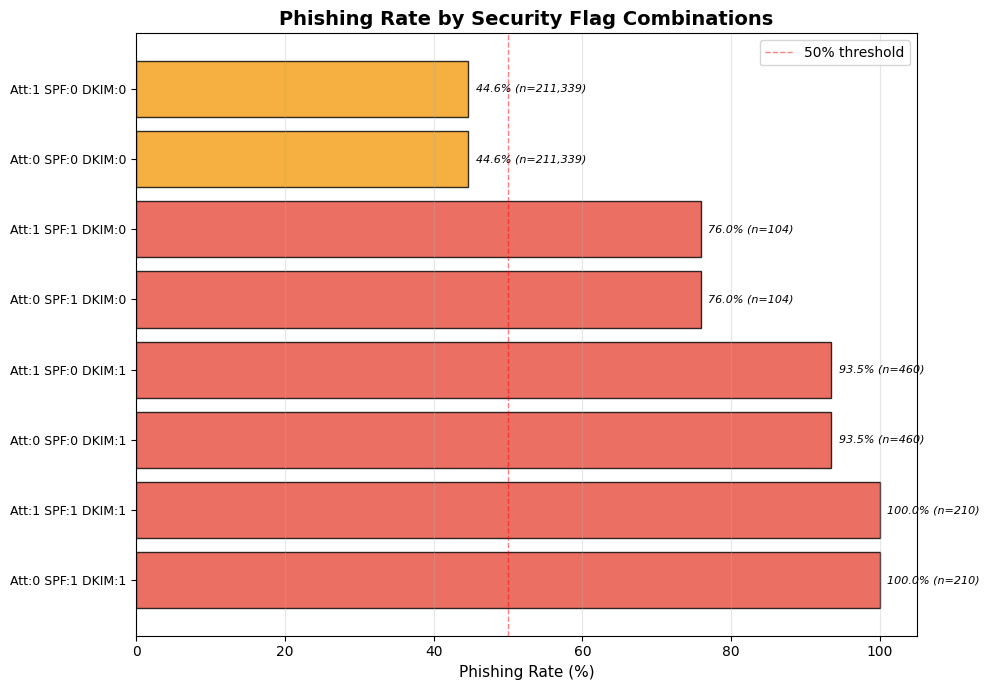

In [19]:
fig, ax = plt.subplots(figsize=(10, 7))

risk_combinations = []
risk_labels = []

for has_att in [0, 1]:
    for spf_miss in [0, 1]:
        for dkim_miss in [0, 1]:
            mask = (
                   (df_pd['spf_flag_missing'] == spf_miss) & 
                   (df_pd['dkim_flag_missing'] == dkim_miss))
            
            total = mask.sum()
            phishing = (mask & (df_pd['phishing'] == 1)).sum()
            phishing_rate = (phishing / total * 100) if total > 0 else 0
            
            if total >= 10: 
                label = f"Att:{has_att} SPF:{spf_miss} DKIM:{dkim_miss}"
                risk_combinations.append({
                    'label': label,
                    'total': total,
                    'phishing_rate': phishing_rate,
                    'spf_missing': spf_miss,
                    'dkim_missing': dkim_miss
                })

risk_combinations.sort(key=lambda x: x['phishing_rate'], reverse=True)

y_pos = np.arange(len(risk_combinations))
rates = [r['phishing_rate'] for r in risk_combinations]
labels = [r['label'] for r in risk_combinations]
totals = [r['total'] for r in risk_combinations]

colors = ['#e74c3c' if rate > 50 else '#f39c12' if rate > 25 else '#2ecc71' 
          for rate in rates]

bars = ax.barh(y_pos, rates, color=colors, edgecolor='black', alpha=0.8)
ax.set_yticks(y_pos)
ax.set_yticklabels(labels, fontsize=9)
ax.set_xlabel('Phishing Rate (%)', fontsize=11)
ax.set_title('Phishing Rate by Security Flag Combinations', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)
ax.axvline(x=50, color='red', linestyle='--', linewidth=1, alpha=0.5, label='50% threshold')
ax.legend()

for i, (bar, rate, total) in enumerate(zip(bars, rates, totals)):
    ax.text(rate + 1, bar.get_y() + bar.get_height()/2,
            f'{rate:.1f}% (n={total:,})',
            ha='left', va='center', fontsize=8, style='italic')

plt.tight_layout()
wandb.log({"dataset_analysis/security_flags_risk": wandb.Image(fig)})
plt.show()
plt.close()

print("Key Insights:")
print(f"Highest risk combination: {risk_combinations[0]['label']} "
      f"({risk_combinations[0]['phishing_rate']:.1f}% phishing rate)")
print(f"Lowest risk combination: {risk_combinations[-1]['label']} "
      f"({risk_combinations[-1]['phishing_rate']:.1f}% phishing rate)")

## 4. Create Standardized Train/Test/External Splits

In [8]:
from app.data_processing.preprocessing_pipeline import PreprocessingPipeline

df = PreprocessingPipeline().process_pipeline(df)
external_df = df.filter(
    (pl.col("source") == "data/csv_misc/TREC-07.csv") | (pl.col("source") == "phishing-2020")
)

train_pool_df = df.filter(
    (pl.col("source") != "data/csv_misc/TREC-07.csv") & (pl.col("source") != "phishing-2020")
)

print(f"Training pool: {len(train_pool_df):,}")
print(f"External validation: {len(external_df):,}")

train_pool_pd = train_pool_df.to_pandas()

train_val_df_pd, test_df_pd = train_test_split(
    train_pool_pd, 
    test_size=0.2, 
    random_state=config["random_seed"], 
    stratify=train_pool_pd['phishing']
)

train_df_pd, val_df_pd = train_test_split(
    train_val_df_pd,
    test_size=0.2,  # Creates 64/16/20 split
    random_state=config["random_seed"],
    stratify=train_val_df_pd['phishing']
)

train_df = pl.from_pandas(train_df_pd)
val_df = pl.from_pandas(val_df_pd) 
test_df = pl.from_pandas(test_df_pd)

print(f"Final splits:")
print(f"Train: {len(train_df):,} ({len(train_df)/len(df)*100:.1f}%)")
print(f"Validation: {len(val_df):,} ({len(val_df)/len(df)*100:.1f}%)") 
print(f"Test: {len(test_df):,} ({len(test_df)/len(df)*100:.1f}%)")
print(f"External: {len(external_df):,} ({len(external_df)/len(df)*100:.1f}%)")

for name, split_df in [("Train", train_df), ("Validation", val_df), ("Test", test_df), ("External", external_df)]:
    phish = split_df.filter(pl.col("phishing") == 1).shape[0]
    total = len(split_df)
    print(f"{name} set:")
    print(f"Phishing: {phish:,} ({phish/total*100:.2f}%)")
    print(f"Legitimate: {total-phish:,} ({(total-phish)/total*100:.2f}%)")
    
    wandb.log({
        f"{name.lower()}_size": total,
        f"{name.lower()}_phishing_ratio": phish / total
    })

numeric_features = config["numeric_features"]

features_train = train_df.select(numeric_features).fill_null(0).to_numpy()
features_val = val_df.select(numeric_features).fill_null(0).to_numpy() 
features_test = test_df.select(numeric_features).fill_null(0).to_numpy()
features_external = external_df.select(numeric_features).fill_null(0).to_numpy()

Training pool: 158,828
External validation: 53,285
Final splits:
Train: 101,649 (47.9%)
Validation: 25,413 (12.0%)
Test: 31,766 (15.0%)
External: 53,285 (25.1%)
Train set:
Phishing: 42,291 (41.60%)
Legitimate: 59,358 (58.40%)
Validation set:
Phishing: 10,573 (41.60%)
Legitimate: 14,840 (58.40%)
Test set:
Phishing: 13,216 (41.60%)
Legitimate: 18,550 (58.40%)
External set:
Phishing: 28,983 (54.39%)
Legitimate: 24,302 (45.61%)


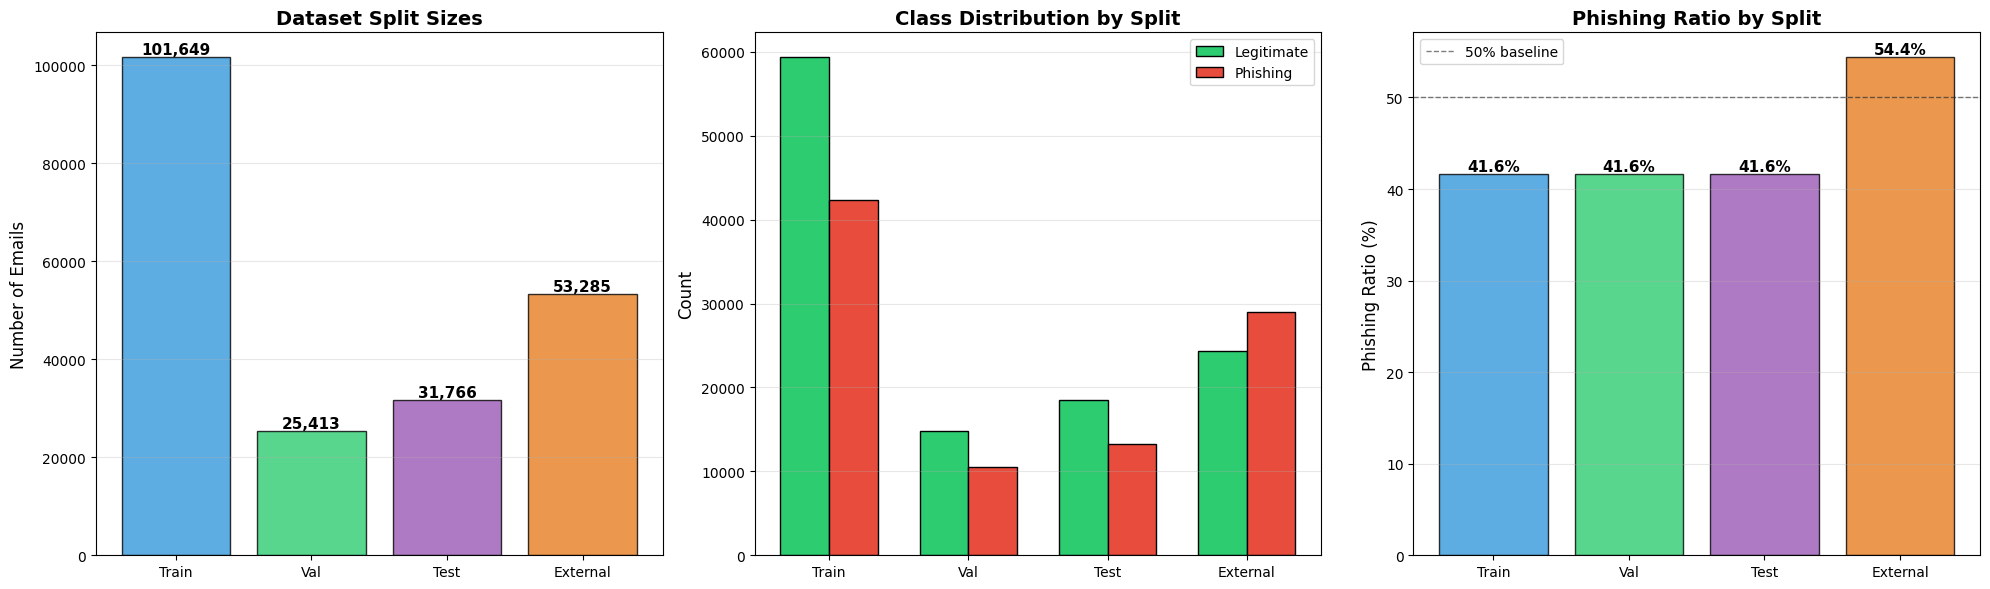

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

splits_data = {
    'Train': train_df,
    'Validation': val_df,
    'Test': test_df,
    'External': external_df
}

ax1 = axes[0]
sizes = [len(train_df), len(val_df), len(test_df), len(external_df)]
colors_splits = ['#3498db', '#2ecc71', '#9b59b6', '#e67e22']
bars = ax1.bar(['Train', 'Val', 'Test', 'External'], sizes, color=colors_splits, edgecolor='black', alpha=0.8)
ax1.set_ylabel('Number of Emails', fontsize=12)
ax1.set_title('Dataset Split Sizes', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

ax2 = axes[1]
x_pos = np.arange(4)
width = 0.35
phishing_counts = [
    train_df.filter(pl.col("phishing") == 1).shape[0],
    val_df.filter(pl.col("phishing") == 1).shape[0],
    test_df.filter(pl.col("phishing") == 1).shape[0],
    external_df.filter(pl.col("phishing") == 1).shape[0]
]
legit_counts = [
    train_df.filter(pl.col("phishing") == 0).shape[0],
    val_df.filter(pl.col("phishing") == 0).shape[0],
    test_df.filter(pl.col("phishing") == 0).shape[0],
    external_df.filter(pl.col("phishing") == 0).shape[0]
]
ax2.bar(x_pos - width/2, legit_counts, width, label='Legitimate', color='#2ecc71', edgecolor='black')
ax2.bar(x_pos + width/2, phishing_counts, width, label='Phishing', color='#e74c3c', edgecolor='black')
ax2.set_ylabel('Count', fontsize=12)
ax2.set_title('Class Distribution by Split', fontsize=14, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(['Train', 'Val', 'Test', 'External'])
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

ax3 = axes[2]
phishing_ratios = [
    phishing_counts[0] / sizes[0] * 100,
    phishing_counts[1] / sizes[1] * 100,
    phishing_counts[2] / sizes[2] * 100,
    phishing_counts[3] / sizes[3] * 100
]
bars = ax3.bar(['Train', 'Val', 'Test', 'External'], phishing_ratios, color=colors_splits, edgecolor='black', alpha=0.8)
ax3.set_ylabel('Phishing Ratio (%)', fontsize=12)
ax3.set_title('Phishing Ratio by Split', fontsize=14, fontweight='bold')
ax3.axhline(y=50, color='black', linestyle='--', linewidth=1, alpha=0.5, label='50% baseline')
ax3.grid(axis='y', alpha=0.3)
ax3.legend()

for bar, ratio in zip(bars, phishing_ratios):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{ratio:.1f}%',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
wandb.log({"dataset_analysis/split_distributions": wandb.Image(fig)})
plt.show()
plt.close()

split_info_data = []
for split_name, split_df_pl in [('Train', train_df), ('Validation', val_df), ('Test', test_df), ('External', external_df)]:
    phish = split_df_pl.filter(pl.col("phishing") == 1).shape[0]
    total = len(split_df_pl)
    split_info_data.append([split_name, total, phish, total - phish, phish / total * 100])

wandb.log({"dataset_analysis/split_info": wandb.Table(
    columns=["split", "total", "phishing", "legitimate", "phishing_ratio_%"],
    data=split_info_data
)})


## 6. Generate Text Embeddings

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Generating embeddings on {device}...")

embedding_model = SentenceTransformer(config["embedding_model"], device=device)

X_emb_train = embedding_model.encode(
    train_df['body_subject'].to_list(), 
    show_progress_bar=True, 
    convert_to_numpy=True,
    batch_size=32
)

X_emb_test = embedding_model.encode(
    test_df['body_subject'].to_list(), 
    show_progress_bar=True, 
    convert_to_numpy=True,
    batch_size=32
)

X_emb_val = embedding_model.encode(
    val_df['body_subject'].to_list(), 
    show_progress_bar=True, 
    convert_to_numpy=True,
    batch_size=32
)

X_emb_external = embedding_model.encode(
    external_df['body_subject'].to_list(), 
    show_progress_bar=True, 
    convert_to_numpy=True,
    batch_size=32
)

y_train = train_df['phishing'].to_numpy()
y_test = test_df['phishing'].to_numpy()
y_external = external_df['phishing'].to_numpy()

print(f"Embedding shapes:")
print(f"Train: {X_emb_train.shape}")
print(f"Test: {X_emb_test.shape}")
print(f"External: {X_emb_external.shape}")

wandb.log({
    "embedding_dim": X_emb_train.shape[1],
    "embedding_model": config["embedding_model"]
})

Generating embeddings on cuda...


Batches: 100%|██████████| 1666/1666 [01:35<00:00, 17.53it/s]


Embedding shapes:
Train: (101649, 384)
Test: (31766, 384)
External: (53285, 384)


## 7. Train TF-IDF Baseline Model

Combined feature shape: (101649, 10011)
TF-IDF features: 10000
Engineered features: 11


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s finished


Using threshold: 0.45
Top 20 most important features:
 1. this fund                      -20.348569
 2. num_links                      -13.896304
 3. league                         -13.301758
 4. business and                   +12.906303
 5. you get                        -11.210447
 6. work                           +10.947712
 7. phonenumber or                 -10.906094
 8. in cash                        -10.290353
 9. henry                          -10.025826
10. expected to                    -10.019066
11. added to                       -9.876053
12. how the                        +9.738189
13. your winning                   +9.603106
14. earned                         -9.464829
15. dreamweaver mx                 -9.405749
16. mostly                         +9.258713
17. performance are                -9.171398
18. inconvenience                  +9.153366
19. as we                          -8.877075
20. need for                       +8.782520


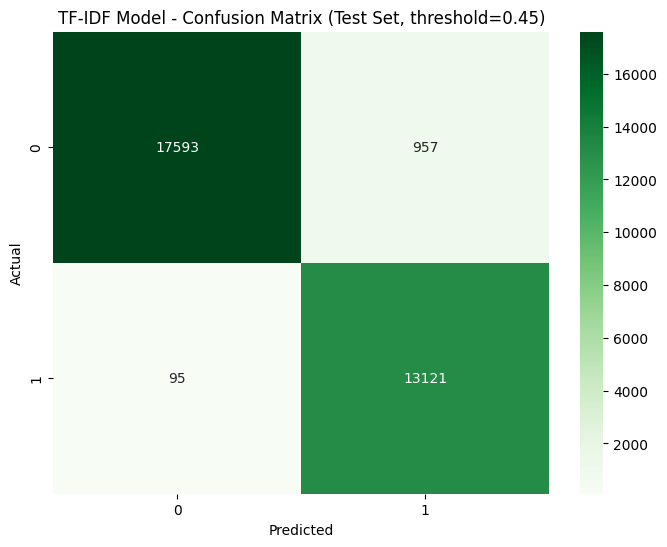

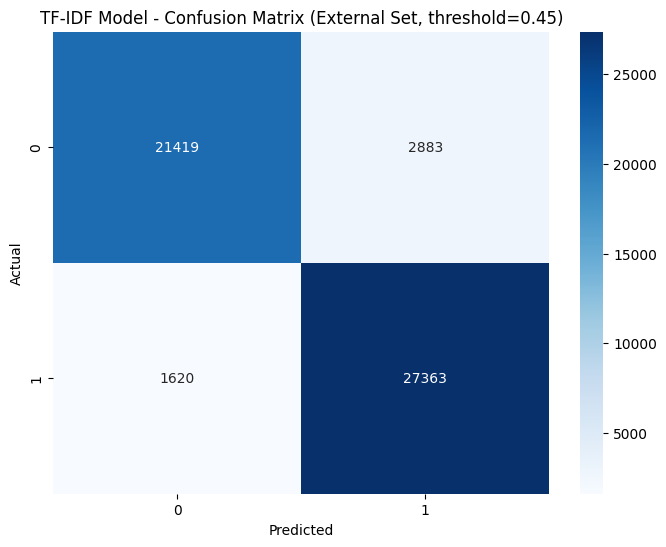

In [11]:
from scipy.sparse import hstack
tfidf = TfidfVectorizer(
    max_features=config["tfidf_max_features"],
    ngram_range=config["tfidf_ngram_range"],
    min_df=config["tfidf_min_df"],
    max_df=config["tfidf_max_df"]
)


X_tfidf_train = tfidf.fit_transform(train_df['body_subject'].to_list())
X_tfidf_test = tfidf.transform(test_df['body_subject'].to_list())
X_tfidf_external = tfidf.transform(external_df['body_subject'].to_list())

X_combined_train = hstack([X_tfidf_train, features_train])
X_combined_test = hstack([X_tfidf_test, features_test])
X_combined_external = hstack([X_tfidf_external, features_external])

print(f"Combined feature shape: {X_combined_train.shape}")
print(f"TF-IDF features: {X_tfidf_train.shape[1]}")
print(f"Engineered features: {features_train.shape[1]}")

class_weights = {0: 1.0, 1: config['lr_class_weight_ratio']}

lr_clf = LogisticRegression(
    max_iter=config["lr_max_iter"],
    C=config["lr_C"],
    class_weight=class_weights,
    random_state=config["random_seed"],
    verbose=1
)
lr_clf.fit(X_combined_train, y_train)

phishing_threshold = config['tfidf_threshold']
print(f"Using threshold: {phishing_threshold}")

y_proba_test_tfidf = lr_clf.predict_proba(X_combined_test)[:, 1]
y_pred_test_tfidf = (y_proba_test_tfidf >= phishing_threshold).astype(int)

tfidf_test_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_test_tfidf),
    'precision': precision_score(y_test, y_pred_test_tfidf, zero_division=0),
    'recall': recall_score(y_test, y_pred_test_tfidf, zero_division=0),
    'f1': f1_score(y_test, y_pred_test_tfidf, zero_division=0),
    'f2': fbeta_score(y_test, y_pred_test_tfidf, beta=2, zero_division=0),
    'roc_auc': roc_auc_score(y_test, y_proba_test_tfidf)
}

y_proba_ext_tfidf = lr_clf.predict_proba(X_combined_external)[:, 1]
y_pred_ext_tfidf = (y_proba_ext_tfidf >= phishing_threshold).astype(int)

tfidf_external_metrics = {
    'accuracy': accuracy_score(y_external, y_pred_ext_tfidf),
    'precision': precision_score(y_external, y_pred_ext_tfidf, zero_division=0),
    'recall': recall_score(y_external, y_pred_ext_tfidf, zero_division=0),
    'f1': f1_score(y_external, y_pred_ext_tfidf, zero_division=0),
    'f2': fbeta_score(y_external, y_pred_ext_tfidf, beta=2, zero_division=0),
    'roc_auc': roc_auc_score(y_external, y_proba_ext_tfidf)
}

feature_names = list(tfidf.vocabulary_.keys()) + numeric_features
coefficients = lr_clf.coef_[0]
feature_importance = sorted(zip(feature_names, coefficients), key=lambda x: abs(x[1]), reverse=True)

print(f"Top 20 most important features:")
for i, (name, coef) in enumerate(feature_importance[:20], 1):
    print(f"{i:2d}. {name:<30s} {coef:+.6f}")

wandb.log({
    "tfidf/phishing_threshold": phishing_threshold,
    "tfidf/class_weight_ratio": config['lr_class_weight_ratio'],
    "tfidf/test_accuracy": tfidf_test_metrics['accuracy'],
    "tfidf/test_precision": tfidf_test_metrics['precision'],
    "tfidf/test_recall": tfidf_test_metrics['recall'],
    "tfidf/test_f1": tfidf_test_metrics['f1'],
    "tfidf/test_f2": tfidf_test_metrics['f2'],
    "tfidf/test_roc_auc": tfidf_test_metrics['roc_auc'],
    "tfidf/external_accuracy": tfidf_external_metrics['accuracy'],
    "tfidf/external_precision": tfidf_external_metrics['precision'],
    "tfidf/external_recall": tfidf_external_metrics['recall'],
    "tfidf/external_f1": tfidf_external_metrics['f1'],
    "tfidf/external_f2": tfidf_external_metrics['f2'],
    "tfidf/external_roc_auc": tfidf_external_metrics['roc_auc'],
})

cm = confusion_matrix(y_test, y_pred_test_tfidf)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title(f'TF-IDF Model - Confusion Matrix (Test Set, threshold={phishing_threshold})')
plt.show()
wandb.log({"tfidf/confusion_matrix": wandb.Image(fig)})
plt.close()

cm = confusion_matrix(y_external, y_pred_ext_tfidf)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title(f'TF-IDF Model - Confusion Matrix (External Set, threshold={phishing_threshold})')
plt.show()
wandb.log({"tfidf/confusion_matrix": wandb.Image(fig)})
plt.close()

## 8. Train Hybrid XGBoost Model


Training XGBoost...
[0]	validation_0-logloss:0.93123	validation_0-auc:0.88855	validation_1-logloss:0.93322	validation_1-auc:0.87856
[10]	validation_0-logloss:0.54234	validation_0-auc:0.97828	validation_1-logloss:0.55787	validation_1-auc:0.96895
[20]	validation_0-logloss:0.38351	validation_0-auc:0.98764	validation_1-logloss:0.40715	validation_1-auc:0.97920
[30]	validation_0-logloss:0.29315	validation_0-auc:0.99211	validation_1-logloss:0.32188	validation_1-auc:0.98435
[40]	validation_0-logloss:0.23479	validation_0-auc:0.99468	validation_1-logloss:0.26720	validation_1-auc:0.98755
[50]	validation_0-logloss:0.19386	validation_0-auc:0.99625	validation_1-logloss:0.22960	validation_1-auc:0.98957
[60]	validation_0-logloss:0.16207	validation_0-auc:0.99739	validation_1-logloss:0.20082	validation_1-auc:0.99112
[70]	validation_0-logloss:0.14184	validation_0-auc:0.99800	validation_1-logloss:0.18272	validation_1-auc:0.99204
[80]	validation_0-logloss:0.12358	validation_0-auc:0.99850	validation_1-logl

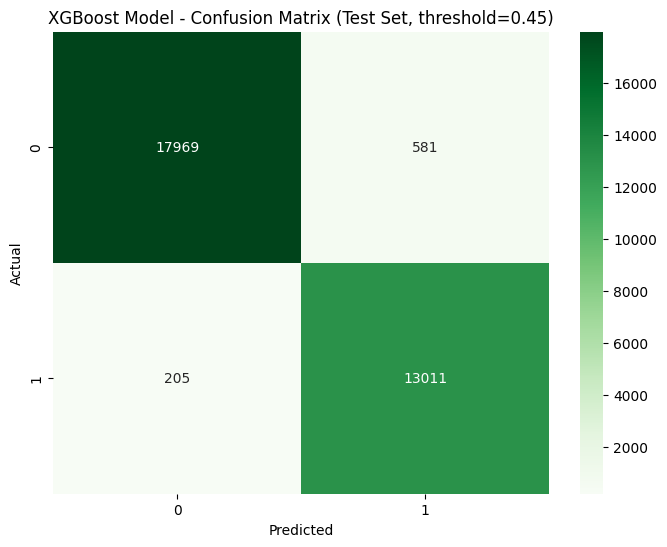

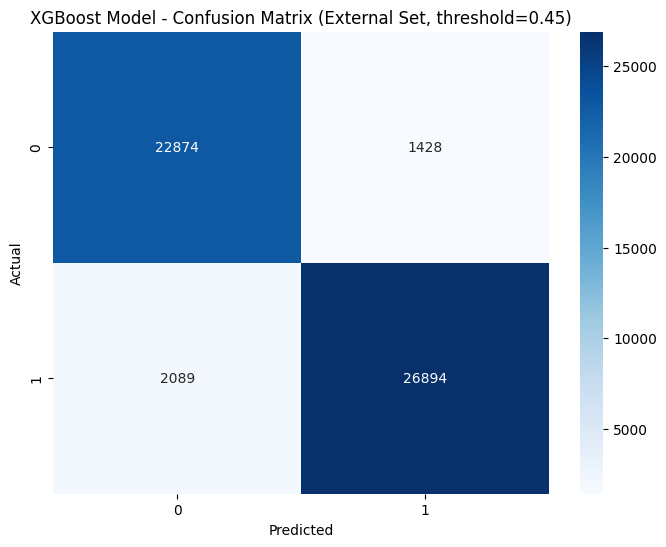

In [ ]:
X_xgb_train = np.concatenate([X_emb_train, features_train], axis=1)
X_xgb_val = np.concatenate([X_emb_val, features_val], axis=1)
X_xgb_test = np.concatenate([X_emb_test, features_test], axis=1)
X_xgb_external = np.concatenate([X_emb_external, features_external], axis=1)

y_train_xgb = train_df['phishing'].to_numpy()
y_val_xgb = val_df['phishing'].to_numpy()

scale_pos_weight = config['xgb_scale_pos_weight']

xgb_clf = xgb.XGBClassifier(
    max_depth=config["xgb_max_depth"],
    n_estimators=config["xgb_n_estimators"],
    learning_rate=config["xgb_learning_rate"],
    min_child_weight=config["xgb_min_child_weight"],
    subsample=config["xgb_subsample"],
    colsample_bytree=config["xgb_colsample_bytree"],
    scale_pos_weight=scale_pos_weight,
    random_state=config["random_seed"],
    eval_metric=["logloss", "auc"],
    early_stopping_rounds=config["xgb_early_stopping"],
    callbacks=[wandb.xgboost.WandbCallback(log_model=True)]
)

xgb_clf.fit(
    X_xgb_train, y_train_xgb,
    eval_set=[(X_xgb_train, y_train_xgb), (X_xgb_val, y_val_xgb)],
    verbose=10
)

phishing_threshold = config['xgb_threshold']
print(f"Using threshold: {phishing_threshold}")

# Evaluate on test set
y_proba_test_xgb = xgb_clf.predict_proba(X_xgb_test)[:, 1]
y_pred_test_xgb = (y_proba_test_xgb >= phishing_threshold).astype(int)

xgb_test_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_test_xgb),
    'precision': precision_score(y_test, y_pred_test_xgb, zero_division=0),
    'recall': recall_score(y_test, y_pred_test_xgb, zero_division=0),
    'f1': f1_score(y_test, y_pred_test_xgb, zero_division=0),
    'f2': fbeta_score(y_test, y_pred_test_xgb, beta=2, zero_division=0),
    'roc_auc': roc_auc_score(y_test, y_proba_test_xgb)
}

# Evaluate on external set
y_proba_ext_xgb = xgb_clf.predict_proba(X_xgb_external)[:, 1]
y_pred_ext_xgb = (y_proba_ext_xgb >= phishing_threshold).astype(int)

xgb_external_metrics = {
    'accuracy': accuracy_score(y_external, y_pred_ext_xgb),
    'precision': precision_score(y_external, y_pred_ext_xgb, zero_division=0),
    'recall': recall_score(y_external, y_pred_ext_xgb, zero_division=0),
    'f1': f1_score(y_external, y_pred_ext_xgb, zero_division=0),
    'f2': fbeta_score(y_external, y_pred_ext_xgb, beta=2, zero_division=0),
    'roc_auc': roc_auc_score(y_external, y_proba_ext_xgb)
}

print(f"XGBoost Hybrid Model (threshold={phishing_threshold})")
print(f"Test Set Performance:")
print(f"Accuracy:{xgb_test_metrics['accuracy']:.4f}")
print(f"Precision:{xgb_test_metrics['precision']:.4f}")
print(f"Recall:{xgb_test_metrics['recall']:.4f}")
print(f"F1 Score:{xgb_test_metrics['f1']:.4f}")
print(f"ROC-AUC:{xgb_test_metrics['roc_auc']:.4f}")

print(f"External Validation:")
print(f"Accuracy:{xgb_external_metrics['accuracy']:.4f}")
print(f"Precision:{xgb_external_metrics['precision']:.4f}")
print(f"Recall:{xgb_external_metrics['recall']:.4f}")
print(f"F1 Score:{xgb_external_metrics['f1']:.4f}")
print(f"ROC-AUC:{xgb_external_metrics['roc_auc']:.4f}")

wandb.log({
    "xgboost/phishing_threshold": phishing_threshold,
    "xgboost/scale_pos_weight": scale_pos_weight,
    "xgboost/test_accuracy": xgb_test_metrics['accuracy'],
    "xgboost/test_precision": xgb_test_metrics['precision'],
    "xgboost/test_recall": xgb_test_metrics['recall'],
    "xgboost/test_f2": xgb_test_metrics['f2'],
    "xgboost/test_roc_auc": xgb_test_metrics['roc_auc'],
    "xgboost/external_accuracy": xgb_external_metrics['accuracy'],
    "xgboost/external_precision": xgb_external_metrics['precision'],
    "xgboost/external_recall": xgb_external_metrics['recall'],
    "xgboost/external_f1": xgb_external_metrics['f1'],
    "xgboost/external_f2": xgb_external_metrics['f2'],
    "xgboost/external_roc_auc": xgb_external_metrics['roc_auc'],
})

cm = confusion_matrix(y_test, y_pred_test_xgb)
fig_cm, ax_cm = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', ax=ax_cm)
ax_cm.set_xlabel('Predicted')
ax_cm.set_ylabel('Actual')
ax_cm.set_title(f'XGBoost Model - Confusion Matrix (Test Set, threshold={phishing_threshold})')
wandb.log({"xgboost/confusion_matrix_test": wandb.Image(fig_cm)})
plt.show()
plt.close()

cm = confusion_matrix(y_external, y_pred_ext_xgb)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title(f'XGBoost Model - Confusion Matrix (External Set, threshold={phishing_threshold})')
wandb.log({"xgboost/confusion_matrix_external": wandb.Image(fig)})

plt.show()
plt.close()

## 9. Train Hybrid MLP Model

In [ ]:
from hybrid_mlp_model import HybridMLPClassifier



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mlp_model = HybridMLPClassifier(
    embedding_dim=config["embedding_dim"],
    num_features=len(numeric_features),
    feature_hidden_dim=config["mlp_feature_hidden_dim"],
    dropout=config["mlp_dropout"]
).to(device)

print(mlp_model)

train_dataset = TensorDataset(
    torch.FloatTensor(X_emb_train), 
    torch.FloatTensor(features_train),
    torch.FloatTensor(train_df['phishing'].to_numpy())
)

val_dataset = TensorDataset(
    torch.FloatTensor(X_emb_val), 
    torch.FloatTensor(features_val),
    torch.FloatTensor(val_df['phishing'].to_numpy())
)
test_dataset = TensorDataset(
    torch.FloatTensor(X_emb_test),
    torch.FloatTensor(features_test),
    torch.FloatTensor(test_df['phishing'].to_numpy())
)

train_loader = DataLoader(train_dataset, batch_size=config["mlp_batch_size"], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config["mlp_batch_size"], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=config["mlp_batch_size"], shuffle=False)

optimizer = torch.optim.Adam(
    mlp_model.parameters(), 
    lr=config["mlp_lr"], 
    weight_decay=config["mlp_weight_decay"]
)

pos_weight = torch.tensor([config['mlp_pos_weight']], device=device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

best_val_loss = float('inf')
patience_counter = 0

for epoch in range(config["mlp_epochs"]):
    mlp_model.train()
    train_loss = 0
    for embeddings, features, labels in train_loader:
        embeddings, features, labels = embeddings.to(device), features.to(device), labels.to(device)
        
        optimizer.zero_grad()
        logits = mlp_model(embeddings, features).squeeze()
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    
    mlp_model.eval()
    val_loss = 0
    val_preds = []
    val_labels = []
    
    with torch.no_grad():
        for embeddings, features, labels in val_loader:
            embeddings, features, labels = embeddings.to(device), features.to(device), labels.to(device)
            
            logits = mlp_model(embeddings, features).squeeze()
            loss = criterion(logits, labels)
            val_loss += loss.item()
            
            probs = torch.sigmoid(logits)
            val_preds.extend(probs.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
    
    val_loss /= len(val_loader)
    val_preds = np.array(val_preds)
    val_labels = np.array(val_labels)
    val_pred_binary = (val_preds > 0.5).astype(int)
    
    val_acc = accuracy_score(val_labels, val_pred_binary)
    val_f1 = f1_score(val_labels, val_pred_binary, zero_division=0)
    
    wandb.log({
        "mlp/epoch": epoch,
        "mlp/train_loss": train_loss,
        "mlp/val_loss": val_loss,
        "mlp/val_accuracy": val_acc,
        "mlp/val_f1": val_f1
    })
    
    print(f"Epoch {epoch+1}/{config['mlp_epochs']}: "
          f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
          f"Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = mlp_model.state_dict().copy()
    else:
        patience_counter += 1
        if patience_counter >= config["mlp_early_stopping"]:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

mlp_model.load_state_dict(best_model_state)

HybridMLPClassifier(
  (feature_branch): Sequential(
    (0): Linear(in_features=11, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
)

Training MLP...
Epoch 1/50: Train Loss: 0.2836 | Val Loss: 0.1864 | Val Acc: 0.9480 | Val F1: 0.9386
Epoch 2/50: Train Loss: 0.1607 | Val Loss: 0.1362 | Val Acc: 0.9643 | Val F1: 0.9576
Epoch 3/50: Train Loss: 0.1256 | Val Loss: 0.1132 | Val Acc: 0.9671 | Val F1: 0.9612
Epoch 4/50: Train Loss: 0.1061 | Val Loss: 0.1040 | Val Acc: 0.9696 | Val F1: 0.9641
Epoch 5/50: Train Loss: 0.0947 | Val Loss: 0.0974 | Val Acc: 0.9746 | Val F1: 0.9697
Epoch 6/50: Train Loss: 0.0869 | Val Loss: 0.0898 | Val A

<All keys matched successfully>


Using threshold: 0.4

MLP Hybrid Model (threshold=0.4)

Test Set Performance:
  Accuracy:  0.9804
  Precision: 0.9685
  Recall:    0.9850
  F1 Score:  0.9767
  ROC-AUC:   0.9981

External Validation:
  Accuracy:  0.9350
  Precision: 0.9610
  Recall:    0.9177
  F1 Score:  0.9389
  ROC-AUC:   0.9808


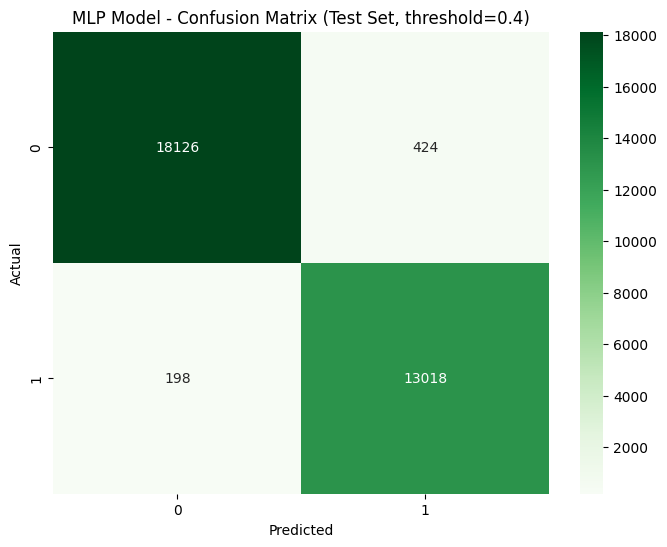

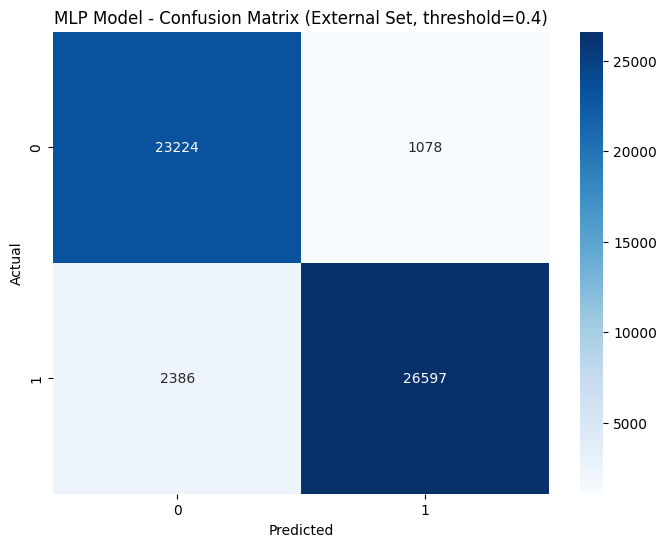

In [ ]:
phishing_threshold = config['mlp_threshold']
print(f"Using threshold: {phishing_threshold}")

mlp_model.eval()
test_preds = []
test_labels = []
test_probs = []

with torch.no_grad():
    for embeddings, features, labels in test_loader:
        embeddings, features = embeddings.to(device), features.to(device)
        
        logits = mlp_model(embeddings, features).squeeze()
        probs = torch.sigmoid(logits)
        
        if probs.dim() == 0:
            test_probs.append(probs.cpu().item())
            test_labels.append(labels.item())
        else:
            test_probs.extend(probs.cpu().numpy())
            test_labels.extend(labels.numpy())

test_probs = np.array(test_probs)
test_labels = np.array(test_labels)
test_preds = (test_probs >= phishing_threshold).astype(int)

mlp_test_metrics = {
    'accuracy': accuracy_score(test_labels, test_preds),
    'precision': precision_score(test_labels, test_preds, zero_division=0),
    'recall': recall_score(test_labels, test_preds, zero_division=0),
    'f1': f1_score(test_labels, test_preds, zero_division=0),
    'f2': fbeta_score(test_labels, test_preds, beta=2, zero_division=0),
    'roc_auc': roc_auc_score(test_labels, test_probs)
}

external_dataset = TensorDataset(
    torch.FloatTensor(X_emb_external),
    torch.FloatTensor(features_external),
    torch.FloatTensor(y_external)
)
external_loader = DataLoader(external_dataset, batch_size=config["mlp_batch_size"], shuffle=False)

ext_preds = []
ext_labels = []
ext_probs = []

with torch.no_grad():
    for embeddings, features, labels in external_loader:
        embeddings, features = embeddings.to(device), features.to(device)
        
        logits = mlp_model(embeddings, features).squeeze()
        probs = torch.sigmoid(logits)
        
        if probs.dim() == 0:
            ext_probs.append(probs.cpu().item())
            ext_labels.append(labels.item())
        else:
            ext_probs.extend(probs.cpu().numpy())
            ext_labels.extend(labels.numpy())

ext_probs = np.array(ext_probs)
ext_labels = np.array(ext_labels)
ext_preds = (ext_probs >= phishing_threshold).astype(int)

mlp_external_metrics = {
    'accuracy': accuracy_score(ext_labels, ext_preds),
    'precision': precision_score(ext_labels, ext_preds, zero_division=0),
    'recall': recall_score(ext_labels, ext_preds, zero_division=0),
    'f1': f1_score(ext_labels, ext_preds, zero_division=0),
    'f2': fbeta_score(ext_labels, ext_preds, beta=2, zero_division=0),
    'roc_auc': roc_auc_score(ext_labels, ext_probs)
}

print(f"MLP Hybrid Model (threshold={phishing_threshold})")
print(f"Accuracy: {mlp_test_metrics['accuracy']:.4f}")
print(f"Precision: {mlp_test_metrics['precision']:.4f}")
print(f"Recall: {mlp_test_metrics['recall']:.4f}")
print(f"F1 Score: {mlp_test_metrics['f1']:.4f}")
print(f"ROC-AUC: {mlp_test_metrics['roc_auc']:.4f}")

print(f"External Validation:")
print(f"Accuracy: {mlp_external_metrics['accuracy']:.4f}")
print(f"Precision: {mlp_external_metrics['precision']:.4f}")
print(f"Recall: {mlp_external_metrics['recall']:.4f}")
print(f"F1 Score: {mlp_external_metrics['f1']:.4f}")
print(f"ROC-AUC: {mlp_external_metrics['roc_auc']:.4f}")

wandb.log({
    "mlp/phishing_threshold": phishing_threshold,
    "mlp/pos_weight": config['mlp_pos_weight'],
    "mlp/test_accuracy": mlp_test_metrics['accuracy'],
    "mlp/test_precision": mlp_test_metrics['precision'],
    "mlp/test_recall": mlp_test_metrics['recall'],
    "mlp/test_f2": mlp_test_metrics['f2'],
    "mlp/test_roc_auc": mlp_test_metrics['roc_auc'],
    "mlp/external_accuracy": mlp_external_metrics['accuracy'],
    "mlp/external_precision": mlp_external_metrics['precision'],
    "mlp/external_recall": mlp_external_metrics['recall'],
    "mlp/external_f1": mlp_external_metrics['f1'],
    "mlp/external_f2": mlp_external_metrics['f2'],
    "mlp/external_roc_auc": mlp_external_metrics['roc_auc'],
})

cm = confusion_matrix(test_labels, test_preds)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title(f'MLP Model - Confusion Matrix (Test Set, threshold={phishing_threshold})')
wandb.log({"mlp/confusion_matrix": wandb.Image(fig)})
plt.show()

cm = confusion_matrix(ext_labels, ext_preds)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title(f'MLP Model - Confusion Matrix (External Set, threshold={phishing_threshold})')
wandb.log({"mlp/confusion_matrix": wandb.Image(fig)})

plt.show()
plt.close()

## 9.1. MLP Branch Importance Analysis

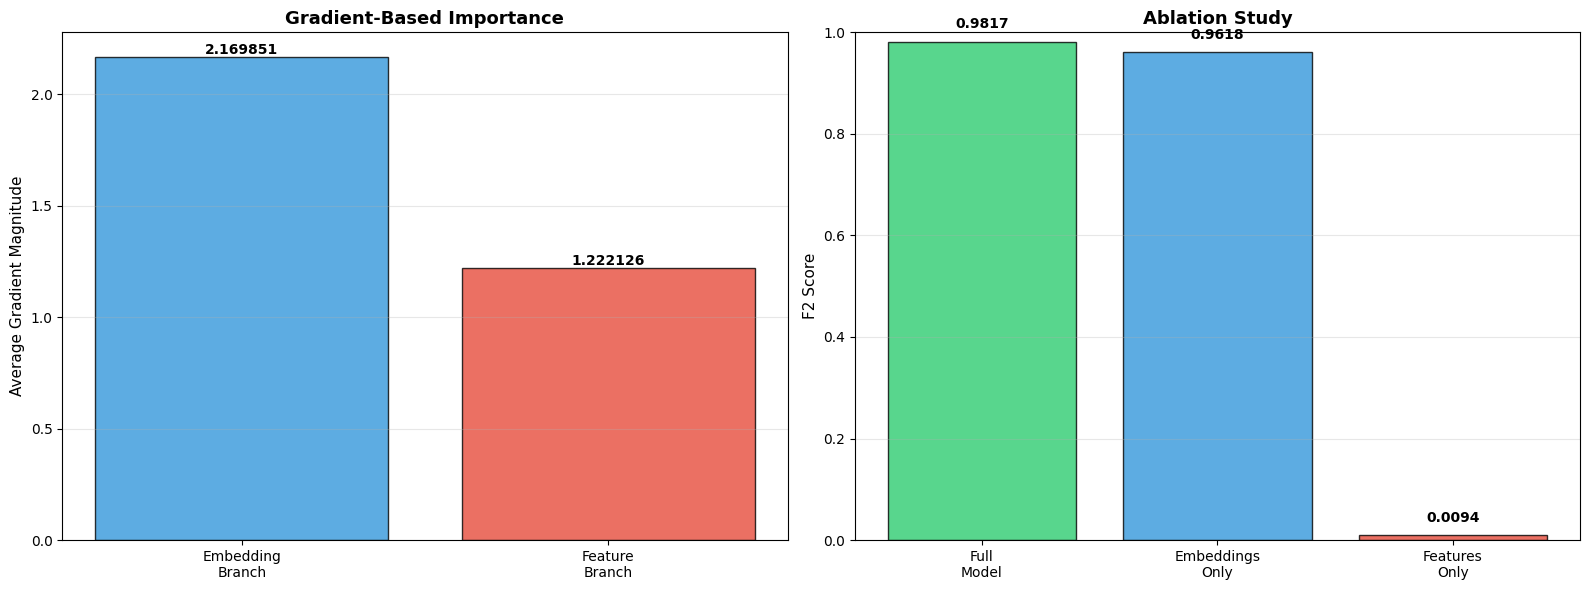

In [ ]:
mlp_model.eval()
sample_size = 500
sample_embeddings = torch.FloatTensor(X_emb_test[:sample_size]).to(device)
sample_features = torch.FloatTensor(features_test[:sample_size]).to(device)

sample_embeddings.requires_grad = True
sample_features.requires_grad = True

logits = mlp_model(sample_embeddings, sample_features)
logits.sum().backward()

embedding_grad_magnitude = sample_embeddings.grad.abs().mean().item()
feature_grad_magnitude = sample_features.grad.abs().mean().item()

def evaluate_with_ablation(embeddings, features, labels, mode='full'):
    mlp_model.eval()
    all_probs = []
    all_labels = []
    
    with torch.no_grad():
        for i in range(0, len(embeddings), config["mlp_batch_size"]):
            batch_emb = embeddings[i:i+config["mlp_batch_size"]].to(device)
            batch_feat = features[i:i+config["mlp_batch_size"]].to(device)
            batch_labels = labels[i:i+config["mlp_batch_size"]]
            
            if mode == 'embeddings_only':
                batch_feat = torch.zeros_like(batch_feat)
            elif mode == 'features_only':
                batch_emb = torch.zeros_like(batch_emb)
            
            logits = mlp_model(batch_emb, batch_feat).squeeze()
            probs = torch.sigmoid(logits)
            
            if probs.dim() == 0:
                all_probs.append(probs.cpu().item())
                all_labels.append(batch_labels.item())
            else:
                all_probs.extend(probs.cpu().numpy())
                all_labels.extend(batch_labels.numpy())
    
    probs = np.array(all_probs)
    labels = np.array(all_labels)
    preds = (probs >= phishing_threshold).astype(int)
    
    metrics = {
        'accuracy': accuracy_score(labels, preds),
        'precision': precision_score(labels, preds, zero_division=0),
        'recall': recall_score(labels, preds, zero_division=0),
        'f2': fbeta_score(labels, preds, beta=2, zero_division=0),
        'roc_auc': roc_auc_score(labels, probs)
    }
    return metrics

test_embeddings = torch.FloatTensor(X_emb_test)
test_features_torch = torch.FloatTensor(features_test)
test_labels_torch = torch.FloatTensor(y_test)

full_model_metrics = evaluate_with_ablation(test_embeddings, test_features_torch, test_labels_torch, mode='full')
embeddings_only_metrics = evaluate_with_ablation(test_embeddings, test_features_torch, test_labels_torch, mode='embeddings_only')
features_only_metrics = evaluate_with_ablation(test_embeddings, test_features_torch, test_labels_torch, mode='features_only')

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

ax1 = axes[0]
branches = ['Embedding Branch', 'Feature Branch']
grad_values = [embedding_grad_magnitude, feature_grad_magnitude]
colors_branch = ['#3498db', '#e74c3c']
bars = ax1.bar(branches, grad_values, color=colors_branch, edgecolor='black', alpha=0.8)
ax1.set_ylabel('Average Gradient Magnitude', fontsize=11)
ax1.set_title('Gradient-Based Importance', fontsize=13, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
for bar, val in zip(bars, grad_values):
    ax1.text(bar.get_x() + bar.get_width()/2, val, f'{val:.6f}', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

ax2 = axes[1]
configs = ['Full Model', 'Embeddings Only', 'Features Only']
f2_scores = [full_model_metrics['f2'], embeddings_only_metrics['f2'], features_only_metrics['f2']]
colors_ablation = ['#2ecc71', '#3498db', '#e74c3c']
bars = ax2.bar(configs, f2_scores, color=colors_ablation, edgecolor='black', alpha=0.8)
ax2.set_ylabel('F2 Score', fontsize=11)
ax2.set_title('Ablation Study', fontsize=13, fontweight='bold')
ax2.set_ylim([0, 1.0])
ax2.grid(axis='y', alpha=0.3)
for bar, val in zip(bars, f2_scores):
    ax2.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.4f}', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()
plt.close()

analysis_summary = [
    ['Gradient Magnitude', 'Embedding Branch', embedding_grad_magnitude],
    ['Gradient Magnitude', 'Feature Branch', feature_grad_magnitude],
    ['Ablation F2', 'Full Model', full_model_metrics['f2']],
    ['Ablation F2', 'Embeddings Only', embeddings_only_metrics['f2']],
    ['Ablation F2', 'Features Only', features_only_metrics['f2']],
]

## 10. Compare Model Performance

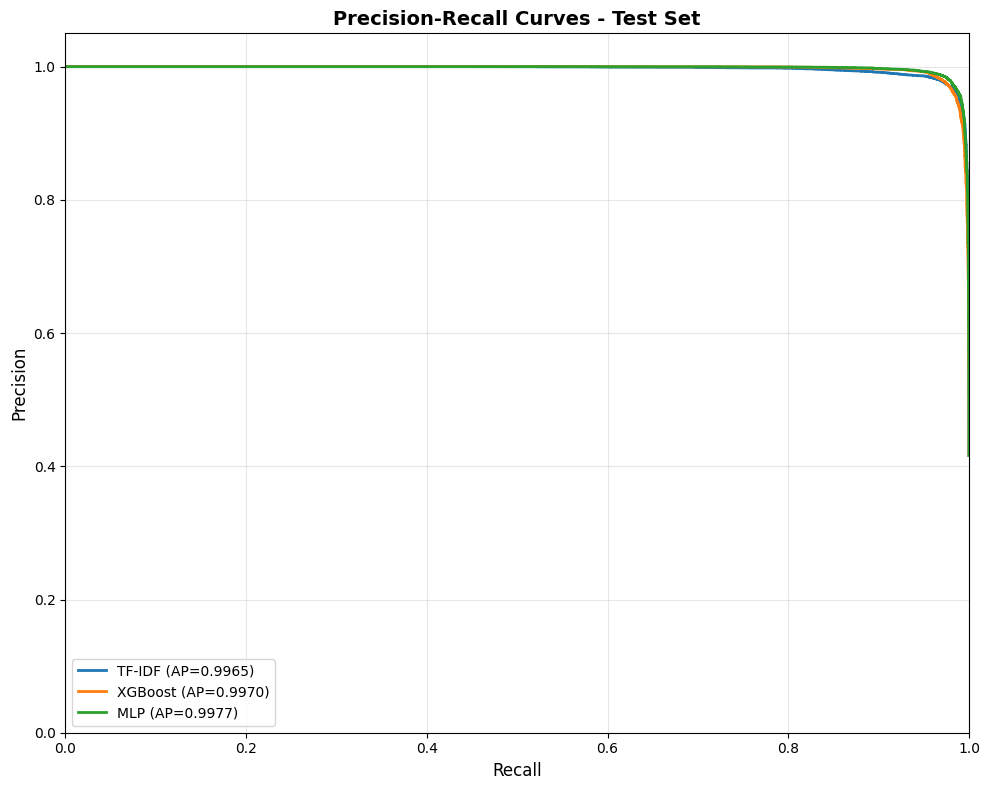

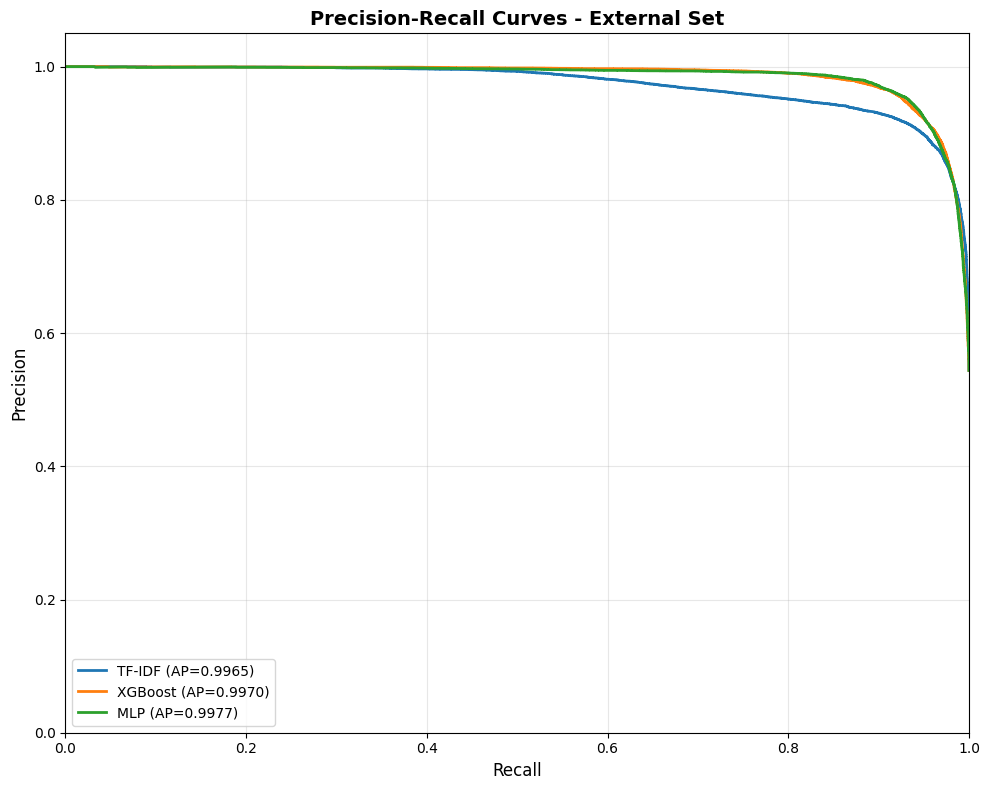


TEST SET PERFORMANCE:
Model                Accuracy     Precision    Recall       F1           F2           ROC-AUC     
--------------------------------------------------------------------------------------------
TF-IDF + LogReg      0.9669       0.9320       0.9928       0.9615       0.9800       0.9975      
XGBoost Hybrid       0.9753       0.9573       0.9845       0.9707       0.9789       0.9975      
MLP Hybrid           0.9804       0.9685       0.9850       0.9767       0.9817       0.9981      

EXTERNAL VALIDATION SET PERFORMANCE:
Model                Accuracy     Precision    Recall       F1           F2           ROC-AUC     
--------------------------------------------------------------------------------------------
TF-IDF + LogReg      0.9155       0.9047       0.9441       0.9240       0.9359       0.9693      
XGBoost Hybrid       0.9340       0.9496       0.9279       0.9386       0.9322       0.9812      
MLP Hybrid           0.9350       0.9610       0.9177       

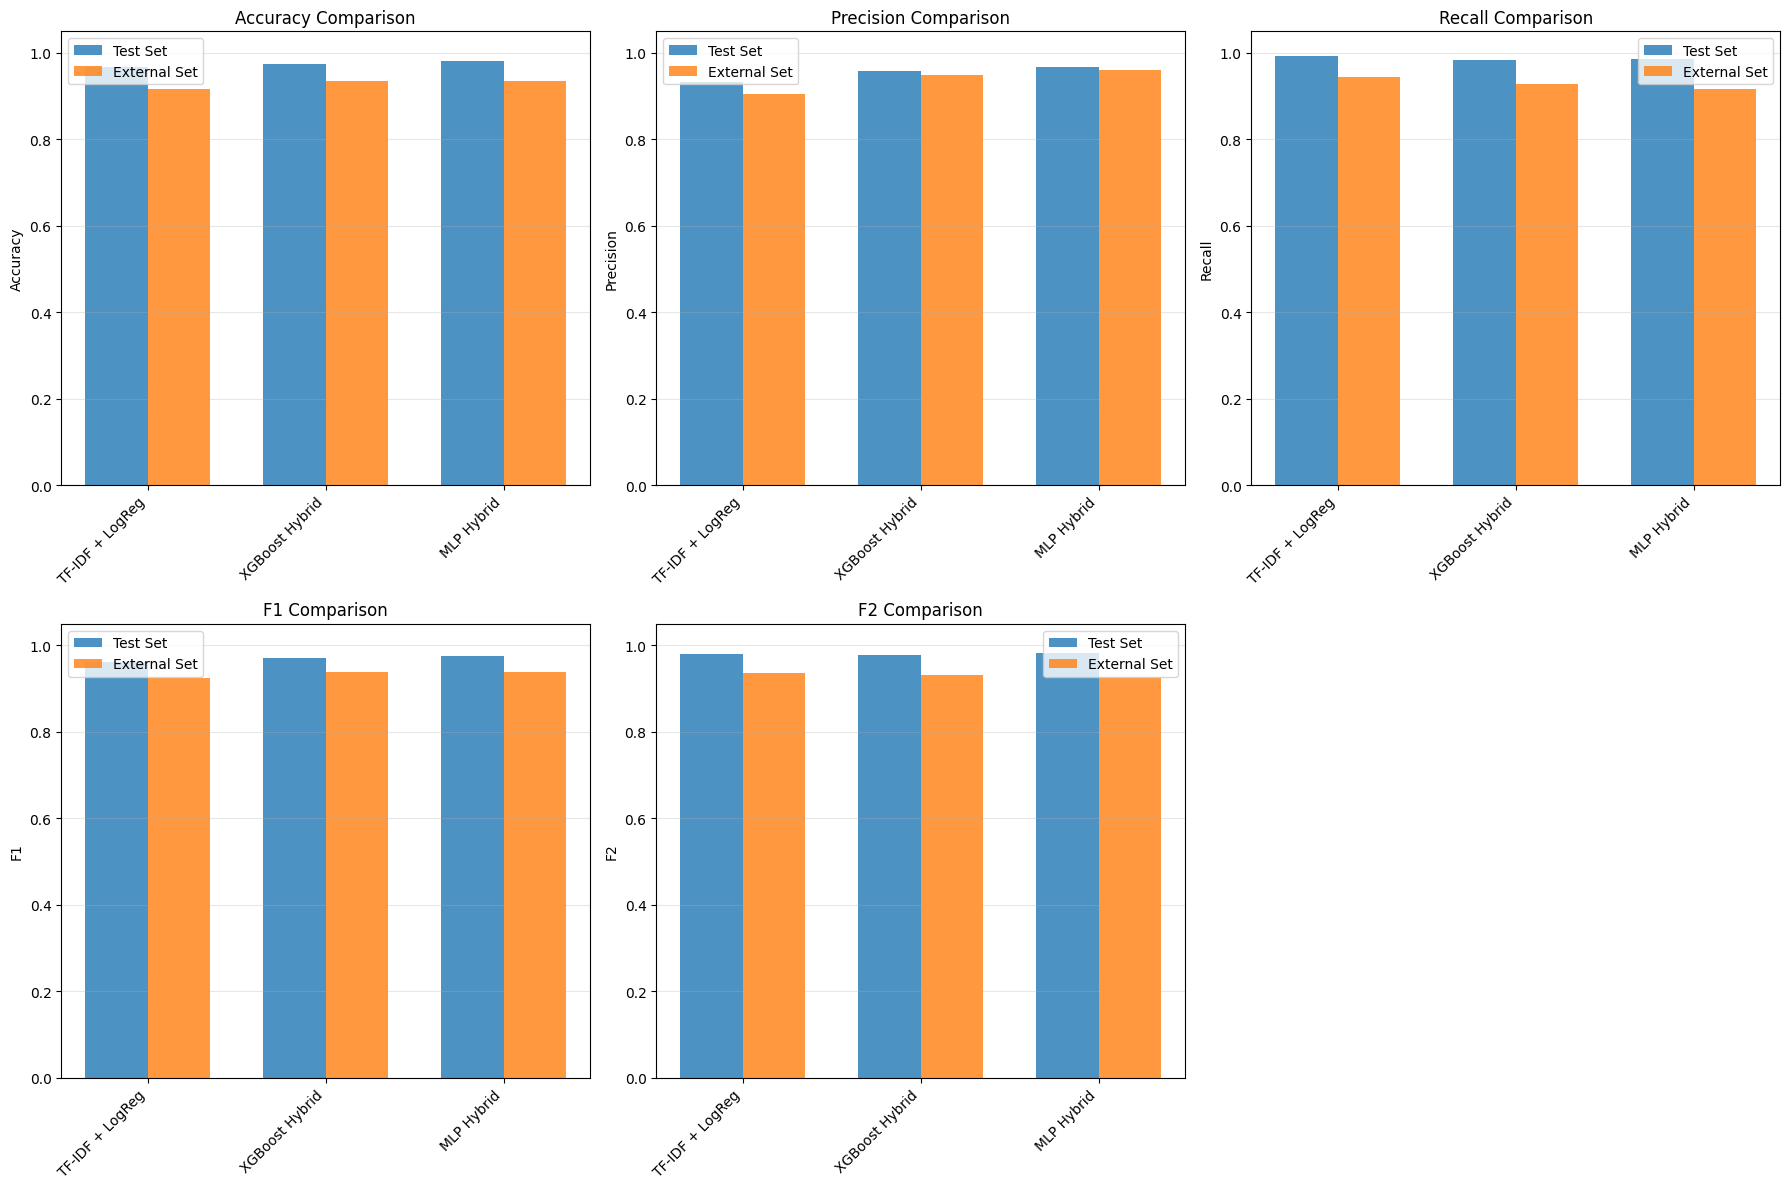

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
comparison_data = {
    'TF-IDF + LogReg': {
        'test': tfidf_test_metrics,
        'external': tfidf_external_metrics
    },
    'XGBoost Hybrid': {
        'test': xgb_test_metrics,
        'external': xgb_external_metrics
    },
    'MLP Hybrid': {
        'test': mlp_test_metrics,
        'external': mlp_external_metrics
    }
}

tfidf_precision_test, tfidf_recall_test, _ = precision_recall_curve(y_test, y_proba_test_tfidf)
xgb_precision_test, xgb_recall_test, _ = precision_recall_curve(y_test, y_proba_test_xgb)
mlp_precision_test, mlp_recall_test, _ = precision_recall_curve(test_labels, test_probs)

tfidf_precision_ex, tfidf_recall_ex, _ = precision_recall_curve(y_external, y_proba_ext_tfidf)
xgb_precision_ex, xgb_recall_ex, _ = precision_recall_curve(y_external, y_proba_ext_xgb)
mlp_precision_ex, mlp_recall_ex, _ = precision_recall_curve(ext_labels, ext_probs)


tfidf_ap = average_precision_score(y_test, y_proba_test_tfidf)
xgb_ap = average_precision_score(y_test, y_proba_test_xgb)
mlp_ap = average_precision_score(test_labels, test_probs)

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(tfidf_recall_test, tfidf_precision_test, label=f'TF-IDF (AP={tfidf_ap:.4f})', linewidth=2)
ax.plot(xgb_recall_test, xgb_precision_test, label=f'XGBoost (AP={xgb_ap:.4f})', linewidth=2)
ax.plot(mlp_recall_test, mlp_precision_test, label=f'MLP (AP={mlp_ap:.4f})', linewidth=2)
ax.set_xlabel('Recall', fontsize=12)
ax.set_ylabel('Precision', fontsize=12)
ax.set_title('Precision-Recall Curves - Test Set', fontsize=14, fontweight='bold')
ax.legend(loc='lower left', fontsize=10)
ax.grid(alpha=0.3)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1.05])

plt.tight_layout()
wandb.log({"comparison/pr_curves": wandb.Image(fig)})
plt.show()
plt.close()

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(tfidf_recall_ex, tfidf_precision_ex, label=f'TF-IDF (AP={tfidf_ap:.4f})', linewidth=2)
ax.plot(xgb_recall_ex, xgb_precision_ex, label=f'XGBoost (AP={xgb_ap:.4f})', linewidth=2)
ax.plot(mlp_recall_ex, mlp_precision_ex, label=f'MLP (AP={mlp_ap:.4f})', linewidth=2)
ax.set_xlabel('Recall', fontsize=12)
ax.set_ylabel('Precision', fontsize=12)
ax.set_title('Precision-Recall Curves - External Set', fontsize=14, fontweight='bold')
ax.legend(loc='lower left', fontsize=10)
ax.grid(alpha=0.3)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1.05])

plt.tight_layout()
wandb.log({"comparison/pr_curves": wandb.Image(fig)})
plt.show()
plt.close()


fig, axes = plt.subplots(2, 3, figsize=(18, 12))
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1', 'f2', 'roc_auc']

for idx, metric in enumerate(metrics_to_plot):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    models = list(comparison_data.keys())
    test_values = [comparison_data[m]['test'][metric] for m in models]
    external_values = [comparison_data[m]['external'][metric] for m in models]
    
    x = np.arange(len(models))
    width = 0.35
    
    ax.bar(x - width/2, test_values, width, label='Test Set', alpha=0.8)
    ax.bar(x + width/2, external_values, width, label='External Set', alpha=0.8)
    
    ax.set_ylabel(metric.replace('_', ' ').title())
    ax.set_title(f'{metric.replace("_", " ").title()} Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45, ha='right')
    ax.legend()
    ax.set_ylim([0, 1.05])
    ax.grid(axis='y', alpha=0.3)


fig.delaxes(axes[1, 2])

plt.tight_layout()
wandb.log({"comparison/metrics_comparison": wandb.Image(fig)})
plt.show()

comparison_table_data = []
for model_name, metrics in comparison_data.items():
    for split, split_metrics in metrics.items():
        row = [model_name, split] + [split_metrics[m] for m in ['accuracy', 'precision', 'recall', 'f1', 'f2', 'roc_auc']]
        comparison_table_data.append(row)

comparison_table = wandb.Table(
    columns=['Model', 'Split', 'Accuracy', 'Precision', 'Recall', 'F1', 'F2', 'ROC-AUC'],
    data=comparison_table_data
)
wandb.log({"comparison/performance_table": comparison_table})


## 11. Save Models and Artifacts


In [ ]:

os.makedirs("../../output/saved_models", exist_ok=True)
os.makedirs("../../output/saved_artifacts", exist_ok=True)

print("Saving models and artifacts...")

with open('../../output/saved_models/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)
with open('../../output/saved_models/tfidf_classifier.pkl', 'wb') as f:
    pickle.dump(lr_clf, f)

xgb_clf.save_model('../../output/saved_models/xgboost_hybrid.json')

torch.save({
    'model_state_dict': mlp_model.state_dict(),
    'embedding_dim': config["embedding_dim"],
    'num_features': len(numeric_features),
    'feature_hidden_dim': config["mlp_feature_hidden_dim"],
    'dropout': config["mlp_dropout"],
    'test_metrics': mlp_test_metrics,
    'external_metrics': mlp_external_metrics,
    'phishing_threshold': config['mlp_threshold'],
    'pos_weight': config['mlp_pos_weight']
}, '../../output/saved_models/mlp_hybrid.pth')


full_config = {
    'experiment_config': config,
    'optuna_optimized': {
        'objective': ' Recall + OC-AUC',
        'description': 'Hyperparameters optimized using Optuna for maximum recall and ranking ability'
    },
    'data_splits': {
        'train_size': len(train_df),
        'test_size': len(test_df),
        'external_size': len(external_df)
    },
    'model_performance': {
        'tfidf': {
            'test': {k: float(v) for k, v in tfidf_test_metrics.items()},
            'external': {k: float(v) for k, v in tfidf_external_metrics.items()}
        },
        'xgboost': {
            'test': {k: float(v) for k, v in xgb_test_metrics.items()},
            'external': {k: float(v) for k, v in xgb_external_metrics.items()}
        },
        'mlp': {
            'test': {k: float(v) for k, v in mlp_test_metrics.items()},
            'external': {k: float(v) for k, v in mlp_external_metrics.items()}
        }
    },
    'feature_names': numeric_features,
    'timestamp': datetime.now().isoformat()
}

with open('../../output/saved_artifacts/experiment_config.json', 'w') as f:
    json.dump(full_config, f, indent=2)


# Upload artifacts to WandB
artifact = wandb.Artifact('phishstop-models-recall-optimized', type='model')
artifact.add_dir('../../output/saved_models')
artifact.add_file('../../output/saved_artifacts/experiment_config.json')
wandb.log_artifact(artifact)


wandb: Adding directory to artifact (..\..\output\saved_models)... Done. 0.0s


Saving models and artifacts...


<Artifact phishstop-models-recall-optimized>

In [ ]:
wandb.finish()


best_iteration,▁
best_score,▁
class_balance,▁
embedding_dim,▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇███
external_phishing_ratio,▁
external_size,▁
legit_count,▁
mlp/epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
mlp/external_accuracy,▁
+55,...


✓ WandB run completed
